# Projet 7 : Implementing a scoring model

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 2 : Modeling

To begin, all necessary libraries are imported

In [89]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
!pip install Imblearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
# Project 7: Implementing a scoring model
# Part 2: Modeling
# Import libraries
import warnings
import pandas as pd
import seaborn as sns
%pylab inline
import timeit

# SHAP library
import shap

# Serialization library
import pickle


from numpy import argmax
from collections import Counter

# Sickit-Learn library
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     cross_validate, cross_val_score,
                                     StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             auc, fbeta_score, roc_auc_score, roc_curve,
                             precision_recall_curve, plot_confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Imblearn library
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import (BalancedRandomForestClassifier,
                               RUSBoostClassifier)

# LightGBM library
from lightgbm import LGBMClassifier

# Hyperopt library
from hyperopt import Trials, fmin, hp, tpe

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [92]:
def feature_engineering(X_train, X_test, y_train, y_test, model,
                        report, global_feat_eng, feat_number, score):
    """This function displays the local or global interpretability
    of a model and the classification metrics.
    """
    features = X_test.columns
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Cross-validation
    cv_results = cross_validate(model,
                                X_train,
                                y_train,
                                cv=StratifiedKFold(n_splits=5),
                                scoring=score,
                                return_train_score=True,
                                n_jobs=-1)
    
    # Training the model
    start_time = timeit.default_timer()
    clf = model.fit(X_train, y_train)
    
    # Making prediction
    y_pred = clf.predict(X_test)
    print("time: {:.2f}s".format(timeit.default_timer() - start_time))

    if report is True:
        # Evaluation of the model performance on the test set
        # Metrics
        print(classification_report(y_test, y_pred))
        print("AUC: {:.2f}".format(
            roc_auc_score(y_test,
                          clf.predict_proba(X_test)[:, 1])))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print("TPR: {:.2f}".format(tp / (tp + fn)))
        print("FPR: {:.2f}".format(fp / (fp + tn)))
        print("TNR: {:.2f}".format(tn / (tn + fp)))
        print("FNR: {:.2f}".format(fn / (fn + tp)))

        # Plot the Confusion matrix
        plt.style.use('default')
        fig, ax0 = plt.subplots(ncols=1, figsize=(3, 3))
        plot_confusion_matrix(clf, X_test, y_test, ax=ax0)
        ax0.set_title('Confusion matrix')
        plt.show()
    
    # Global and local interpretability of the model
    if global_feat_eng is True:
        # Displaying Feature importance
        features_importance = clf.feature_importances_
        sorted_features = np.argsort(features_importance)
        features_df = pd.DataFrame(columns=['Feature', 'Importance value'])
        features_df['Feature'] = np.array(list(features))[sorted_features]
        features_df['Importance value'] = features_importance[sorted_features]
        features_df = features_df.sort_values(['Importance value'],
                                              ascending=False)
        relevant_features = list(features_df.Feature)
        features_df = features_df[features_df['Importance value'] > 0]

        # Plot
        # Setup the figure
        plt.style.use('seaborn')
        fig = plt.figure(figsize=(25, 5))
        ax = sns.barplot(x='Feature', y='Importance value', data=features_df)
        fig = ax.get_figure()
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            ha='right')
        ax.set_title('Feature importance')
        ax.set_xlabel('Feature')
        ax.set_ylabel('Importance value')
        plt.show()
        return relevant_features
    else:
        # SHAP explanations
        shap.initjs()
        shap_explainer = shap.TreeExplainer(clf)
        shap_values = shap_explainer.shap_values(X_test)
        shap.summary_plot(shap_values,
                          X_test,
                          feature_names=features,
                          max_display=feat_number,
                          plot_type='bar',
                          plot_size=(5, 15))
        plt.show()


def classifiers_basic_comparison(X_train, X_test, y_train, y_test,
                                 classifiers, N_FOLDS):
    """This function evaluates the basic performances of classifiers
    in cross-validation using the classification metrics
    and the calculation time.
    """
    classifiers_names = []
    cv_auc =[]
    training_auc = []
    roc_auc = []
    precisions = []
    recalls = []
    score_f1 = []
    tprs = []
    fprs = []
    tnrs = []
    fnrs = []
    Fβ_score = []
    best_thr = []
    times = []
    for classifier in classifiers.keys():
        print("{}: ".format(classifier))
        
        # Instantiate the model
        model = classifiers[classifier]
        
        # Cross-validation
        start_time = timeit.default_timer()
        cv_results = cross_validate(model,
                                    X_train,
                                    y_train,
                                    cv=StratifiedKFold(n_splits=N_FOLDS),
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)
        
        # Training the model
        clf = model.fit(X_train, y_train)
        time = timeit.default_timer() - start_time
        
        # Making prediction
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        
        # Evaluation of the model performance on the test set
        # Metrics
        cv_auc.append(np.mean(cv_results['test_score']))
        training_auc.append(np.mean(cv_results['train_score']))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tprs.append(tp / (tp + fn))
        fprs.append(fp / (fp + tn))
        tnrs.append(tn / (tn + fp))
        fnrs.append(fn / (fn + tp))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        score_f1.append(f1_score(y_test, y_pred))
        times.append(time)
        classifiers_names.append(classifier)
        
        # Get the Fβ score
        β = 3
        Fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        
        # Get the best threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
        idx = argmax(fβscore)
        best_thresholds = thresholds[idx]
        best_thr.append(best_thresholds)
        
        # Plot the Confusion matrix
        plt.style.use('default')
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(121)
        plot_confusion_matrix(clf, X_test, y_test, ax=ax)
        ax.set_title('Confusion matrix')
        
        # Plot the ROC curve 
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auroc = auc(fpr, tpr)
        plt.style.use('seaborn')
        ax = fig.add_subplot(122)
        ax.plot(fpr, tpr, color='red', label='AUC={:.2f}'.format(auroc))
        ax.legend(loc='lower right')
        ax.plot([0, 1], [0, 1], linestyle='--')
        plt.axis('tight')
        plt.title('Receiver Operating Characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Creation of the ranking dataframe
    classification = pd.DataFrame(
        columns=['Classifiers',
                 'Cross-validation AUC',
                 'Prediction AUC',
                 'Training AUC',
                 'Precision',
                 'Recall',
                 'F1 score',
                 'TPR',
                 'FPR',
                 'TNR',
                 'FNR',
                 'Fβ score',
                 'Best threshold',
                 'time (s)'])
    classification.Classifiers = classifiers_names
    classification['Cross-validation AUC'] = np.round(cv_auc, 2)
    classification['Prediction AUC'] = np.round(roc_auc, 2)
    classification['Training AUC'] = np.round(training_auc, 2)
    classification['Precision'] = np.round(precisions, 2)
    classification['Recall'] = np.round(recalls, 2)
    classification['F1 score'] = np.round(score_f1, 2)
    classification['TPR'] = np.round(tprs, 2)
    classification['FPR'] = np.round(fprs, 2)
    classification['TNR'] = np.round(tnrs, 2)
    classification['FNR'] = np.round(fnrs, 2)
    classification['Fβ score'] = np.round(Fβ_score, 2)
    classification['Best threshold'] = np.round(best_thr, 2)
    classification['time (s)'] = np.round(times, 2)
    classification = classification.set_index('Classifiers')
    classification = classification.sort_values(['Cross-validation AUC'],
                                                ascending=False)
    return classification


def classifiers_comparison(X_train, X_test, y_train, y_test,
                           classifiers, N_FOLDS):
    """This function evaluates the performances of optimized models
    in cross-validation using the classification metrics
    and the fit time.
    """
    classifiers_names = []
    training_auc = []
    cv_auc = []
    roc_auc = []
    precisions = []
    recalls = []
    score_f1 = []
    tprs = []
    fprs = []
    tnrs = []
    fnrs = []
    Fβ_score = []
    best_thr = []
    times = []
    params = []
    for classifier in classifiers.keys():
        classifiers_names.append(classifier)
        print("{}: ".format(classifier))
        
        # Instantiate the model
        model = classifiers[classifier][0]
        
        # Cross-validation
        # Parameters grid for optimization
        param_grid = classifiers[classifier][1]
        
        # Score to optimize
        score = 'roc_auc'
        
        # Creating the grid search model
        model = GridSearchCV(
            # Pipeline from the given classifier
            model,
            # Hyperparameters to test
            param_grid,
            # Number of folds for the cross-validation
            cv=StratifiedKFold(n_splits=N_FOLDS),
            # Score to optimize
            scoring=score,
            # Number of jobs to run in parallel: using all processors
            n_jobs=-1)

        # Training the model
        clf = model.fit(X_train, y_train)
  
        # Classifier
        # Displaying optimal hyperparameters
        best_params = clf.best_params_
        params.append(best_params)
        print(best_params)

        # Making prediction
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
 
        # Evaluation of the model performance on the test set
        # Metrics
        auroc = np.mean(clf.cv_results_['mean_test_score'])
        cv_auc.append(np.abs(auroc))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        training_auc.append(model.score(X_train, y_train))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tprs.append(tp / (tp + fn))
        fprs.append(fp / (fp + tn))
        tnrs.append(tn / (tn + fp))
        fnrs.append(fn / (fn + tp))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        score_f1.append(f1_score(y_test, y_pred))
        mean_fit_time = np.sum(clf.cv_results_['mean_fit_time'])
        times.append(mean_fit_time)

        # Get the Fβ score
        β = 3
        Fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        
        # Get the best threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
        idx = argmax(fβscore)
        best_thresholds = thresholds[idx]
        best_thr.append(best_thresholds)
        
        # Plot the Confusion matrix
        plt.style.use('default')
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(121)
        plot_confusion_matrix(clf, X_test, y_test, ax=ax)
        ax.set_title('Confusion matrix')
        
        # Plot the ROC curve 
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auroc = auc(fpr, tpr)
        plt.style.use('seaborn')
        ax = fig.add_subplot(122)
        ax.plot(fpr, tpr, color='red', label='AUC={:.2f}'.format(auroc))
        ax.legend(loc='lower right')
        ax.plot([0, 1], [0, 1], linestyle='--')
        plt.axis('tight')
        plt.title('Receiver Operating Characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Creating the ranking dataframe
    classification = pd.DataFrame(
        columns=['Classifiers',
                 'Cross-validation AUC',
                 'Prediction AUC',
                 'Training AUC',
                 'Precision',
                 'Recall',
                 'F1 score',
                 'TPR',
                 'FPR',
                 'TNR',
                 'FNR',
                 'Fβ score',
                 'Best threshold',
                 'fit-time (s)'])
    classification.Classifiers = classifiers_names
    classification['Cross-validation AUC'] = np.round(cv_auc, 2)
    classification['Prediction AUC'] = np.round(roc_auc, 2)
    classification['Training AUC'] = np.round(training_auc, 2)
    classification['Precision'] = np.round(precisions, 2)
    classification['Recall'] = np.round(recalls, 2)
    classification['F1 score'] = np.round(score_f1, 2)
    classification['TPR'] = np.round(tprs, 2)
    classification['FPR'] = np.round(fprs, 2)
    classification['TNR'] = np.round(tnrs, 2)
    classification['FNR'] = np.round(fnrs, 2)
    classification['Fβ score'] = np.round(Fβ_score, 2)
    classification['Best threshold'] = np.round(best_thr, 2)
    classification['fit-time (s)'] = np.round(times, 2)
    classification = classification.set_index('Classifiers')
    classification = classification.sort_values(['Cross-validation AUC'],
                                                ascending=False)
    return params, classification


def display_histogram(dataviz, ranking_var, sort, fig_size, color):
    """This function displays a histogram with
    classifiers' comparison results using the metrics.
    """
    dataviz = dataviz.sort_values([ranking_var], ascending=sort)

    # Setup the figure
    plt.style.use('seaborn')
    ax = dataviz.plot(kind='bar', figsize=fig_size, color=color)
    for value in ax.patches:
        ax.annotate(
            value.get_height(),
            (value.get_x() + value.get_width() / 2,
            value.get_height()),
            ha='center',
            va='bottom')
    fig = ax.get_figure()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title('Classification models ranking by {}'.format(ranking_var))
    ax.set_xlabel('Classifiers model')
    ax.set_ylabel('{}'.format(ranking_var))
    plt.show()

## 1. Dataset preprocessing

### 1.1 Importing data

In [93]:
# 1. Dataset preprocessing
# 1.1 Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/p7_alalem_qais/customers_df.csv', sep=',')

# Dimensions of the dataset
print(data.shape)
data.head()

(252137, 64)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,PREV_AMT_ANNUITY,PREV_AMT_DOWN_PAYMENT,PREV_AMT_CREDIT,PREV_RATE_DOWN_PAYMENT,PREV_CNT_PAYMENT,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE
0,100002,1,0,1,1,0.0,202500.0,406597.5,24700.5,0.018801,...,9251.775,0.00,179055.00,0.000000,24.000000,M,Working,Secondary / secondary special,Single / not married,House / apartment
1,100003,1,0,0,0,0.0,270000.0,1293502.5,35698.5,0.003541,...,56553.990,3442.50,484191.00,0.050030,10.000000,F,State servant,Higher education,Married,House / apartment
2,100004,0,1,1,0,0.0,67500.0,135000.0,6750.0,0.010032,...,5357.250,4860.00,20106.00,0.212008,4.000000,M,Working,Secondary / secondary special,Single / not married,House / apartment
3,100006,1,0,1,0,0.0,135000.0,312682.5,29686.5,0.008019,...,23651.175,34840.17,291695.50,0.163412,23.000000,F,Working,Secondary / secondary special,Married,House / apartment
4,100007,1,0,1,0,0.0,121500.0,513000.0,21865.5,0.028663,...,12278.805,3390.75,166638.75,0.159516,20.666667,M,Working,Secondary / secondary special,Single / not married,House / apartment


In [94]:
# Data preprocessing
y = data.TARGET
X_df = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# Feature selection
numeric_features = list(X_df.select_dtypes('int64').nunique().index)
numeric_features.extend(list(X_df.select_dtypes('float64').nunique().index))
cat_features = list(X_df.select_dtypes('object').nunique().index)

# Encoding categorical features
X = pd.get_dummies(X_df, columns=cat_features)
df = X.nunique()
binary_features = list(df[df == 2].index)
num_features = list(df[df != 2].index)
print(X.shape)

# Split into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

(252137, 81)


### 1.2 Imputations, normalization, and standardization

In [95]:
# 1.2 Imputations, normalization, and standardization
# Training set preprocessing
# Imputations
num_imputer = SimpleImputer(missing_values=np.nan,
                            strategy='median')
Xtrain_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_features]),
                          columns=num_features)

bin_imputer = SimpleImputer(missing_values=np.nan,
                            strategy='most_frequent')
Xtrain_bin = pd.DataFrame(bin_imputer.fit_transform(
    X_train[binary_features]), columns=binary_features)

# Normalization
transformer = QuantileTransformer(output_distribution='normal',
                                  random_state=0)
Xtrain_norm = pd.DataFrame(transformer.fit_transform(
    Xtrain_num), columns=num_features)

# Standardization
scaler = RobustScaler()
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain_norm),
                          columns=num_features)

for feature in binary_features:
    Xtrain_std[feature] = Xtrain_bin[feature]
print(Xtrain_std.shape)

(176495, 81)


In [96]:
# Test set preprocessing
# Imputations
Xtest_num = pd.DataFrame(num_imputer.transform(X_test[num_features]),
                         columns=num_features)
Xtest_bin = pd.DataFrame(bin_imputer.transform(X_test[binary_features]),
                         columns=binary_features)

# Normalization
Xtest_norm = pd.DataFrame(transformer.transform(Xtest_num),
                          columns=num_features)

# Standardization
X_test = pd.DataFrame(scaler.transform(Xtest_norm),
                      columns=num_features)

for feature in binary_features:
    X_test[feature] = Xtest_bin[feature]
print(X_test.shape)

(75642, 81)


### 1.3 Classification preformance ecaluation metrics

### 1.4 Transformation of imbalanced dataset

### 1.4.1 Transformation of imbalanced dataset by over-sampling

#### 1.4.1.1 Over-sampling the training set

Pipeline (SMOTE + dummy regressor): 


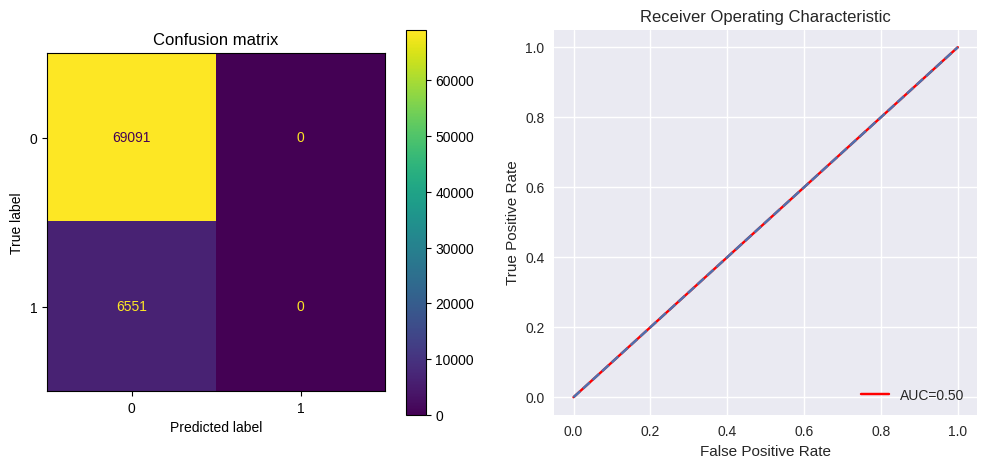

Pipeline (SMOTE + Logistic Regression): 


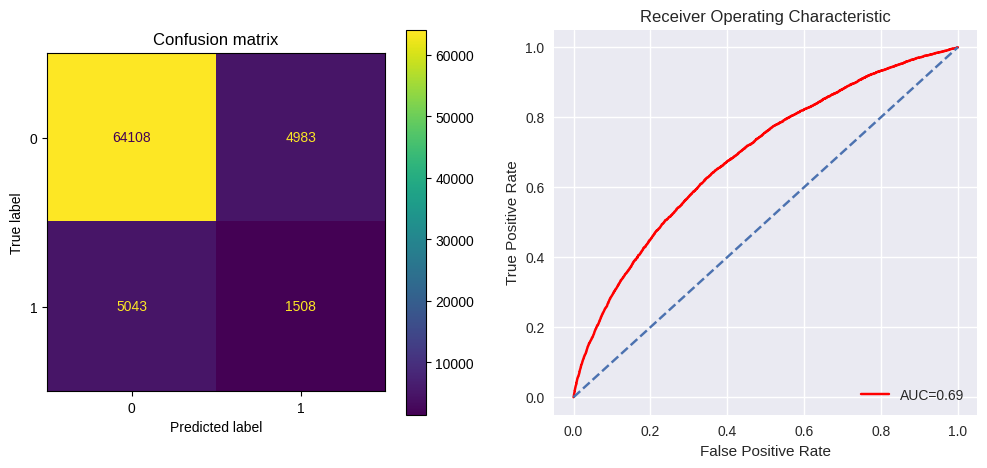

Pipeline (SMOTE + Balanced Random Forest): 


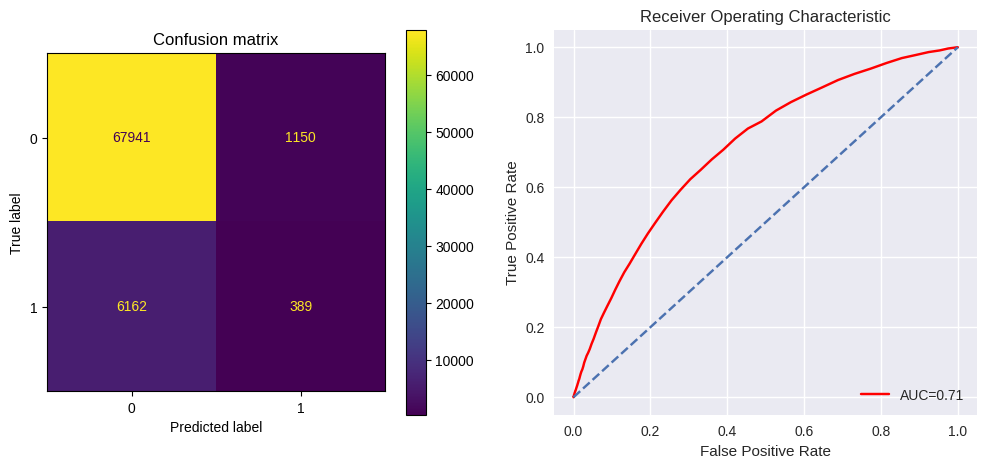

Pipeline (SMOTE + lgbm): 


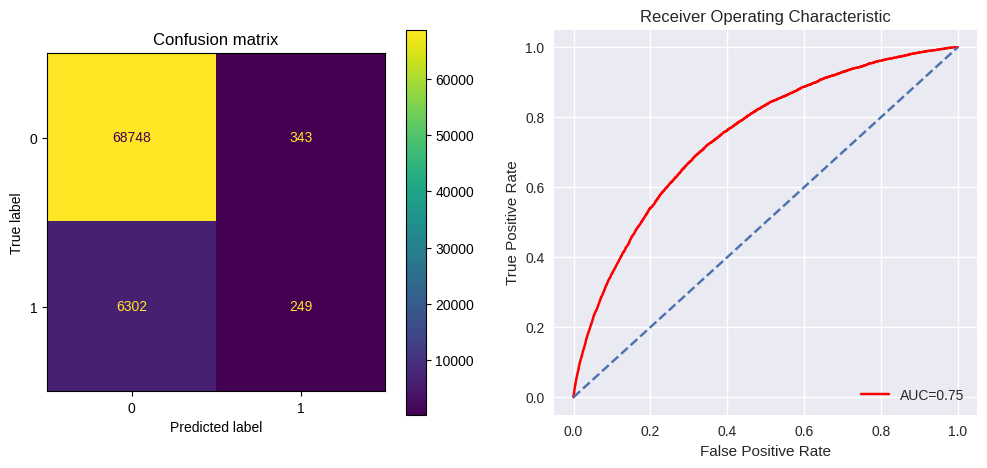

In [97]:
from imblearn.pipeline import Pipeline
smote = SMOTE(random_state=0, n_jobs=-1)
# Define the pipelines
pipeline_lr = Pipeline([('smote', smote),
                        ('classifier', LogisticRegression())])
pipeline_dummy = Pipeline([('smote', smote),
                         ('classifier', DummyClassifier(strategy='most_frequent', random_state=0))])
pipeline_brf = Pipeline([('smote', smote),
                        ('classifier', BalancedRandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1))])
pipeline_lgbm = Pipeline([('smote', smote),
                         ('classifier', LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1))])

# Define the classifiers
classifiers = {'Pipeline (SMOTE + dummy regressor)': pipeline_dummy,
               'Pipeline (SMOTE + Logistic Regression)': pipeline_lr,
               'Pipeline (SMOTE + Balanced Random Forest)': pipeline_brf,
               'Pipeline (SMOTE + lgbm)': pipeline_lgbm}

# Call the classifiers_basic_comparison function
classification_smote = classifiers_basic_comparison(Xtrain_std, X_test, y_train, y_test,
                                         classifiers, 5)

#### 1.4.1.2 Cross-validation and model predictions

Cross validation with chosen models using their base hyperparameters.

In [98]:
# Comparison of the basic performances of the classifiers
classification_smote

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,time (s)
Classifiers,,,,,,,,,,,,,
Pipeline (SMOTE + lgbm),0.75,0.75,0.77,0.42,0.04,0.07,0.04,0.00,1.00,0.96,0.04,0.82,82.56
Pipeline (SMOTE + Balanced Random Forest),0.71,0.71,1.00,0.25,0.06,0.10,0.06,0.02,0.98,0.94,0.06,0.87,692.34
Pipeline (SMOTE + Logistic Regression),0.69,0.69,0.69,0.23,0.23,0.23,0.23,0.07,0.93,0.77,0.23,0.99,54.97
Pipeline (SMOTE + dummy regressor),0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,44.34


### 1.4.2 Transformation of imbalanced dataset by under-sampling

#### 1.4.2.1 Under-sampling the training set

In [99]:
# 1.4.2 Transformation of imbalanced dataset by under-sampling
# 1.4.2.1 Under-sampling the training set
rus = RandomUnderSampler(random_state=0)
X_train_res, y_train_res = rus.fit_resample(Xtrain_std, y_train)
print('Original dataset samples per class: {}'.format(Counter(y_train)))
print('Resampled dataset samples per class: {}'.format(Counter(y_train_res)))
print('Original dataset shape: {}'.format(y_train.shape))
print('Resample dataset shape: {}'.format(y_train_res.shape))
print(X_train_res.shape)

Original dataset samples per class: Counter({0: 161211, 1: 15284})
Resampled dataset samples per class: Counter({0: 15284, 1: 15284})
Original dataset shape: (176495,)
Resample dataset shape: (30568,)
(30568, 81)


#### 1.4.2.2 Cross-validation and model predictions

Cross validation with chosen models using their base hyperparameters.

In [100]:
# 1.4.2.2 Cross-validation and model predictions
classifiers = {
    'Dummy Classifier (Baseline)': DummyClassifier(
        strategy='most_frequent', random_state=0),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=0),
    'RUSBoost': RUSBoostClassifier(random_state=0),
    'Balanced RandomForest': BalancedRandomForestClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1)
}

Dummy Classifier (Baseline): 


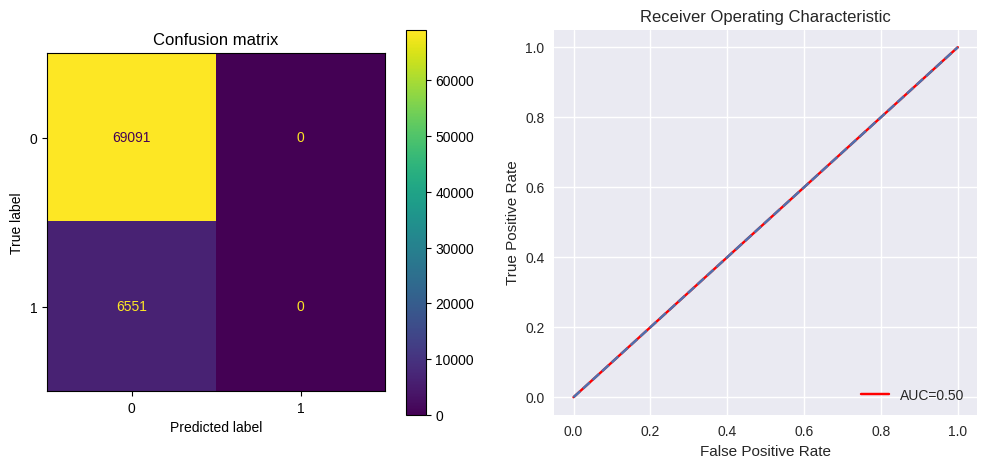

Logistic Regression: 


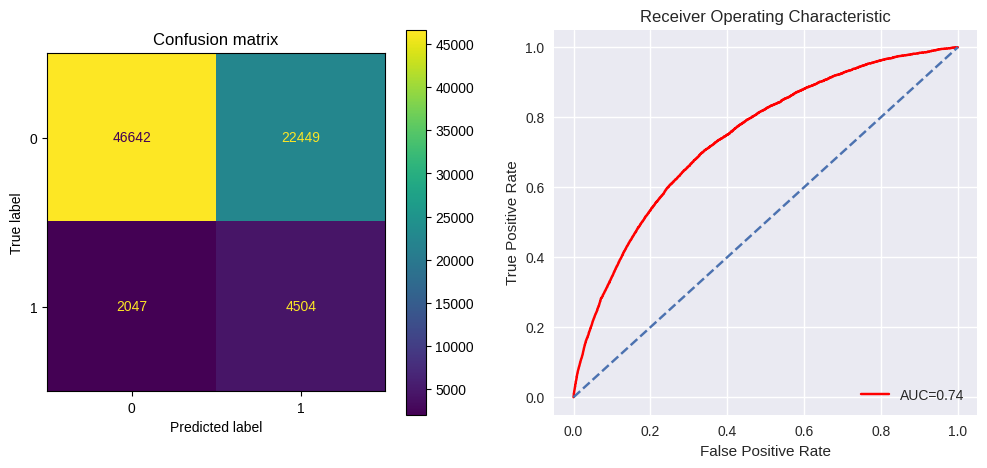

RUSBoost: 


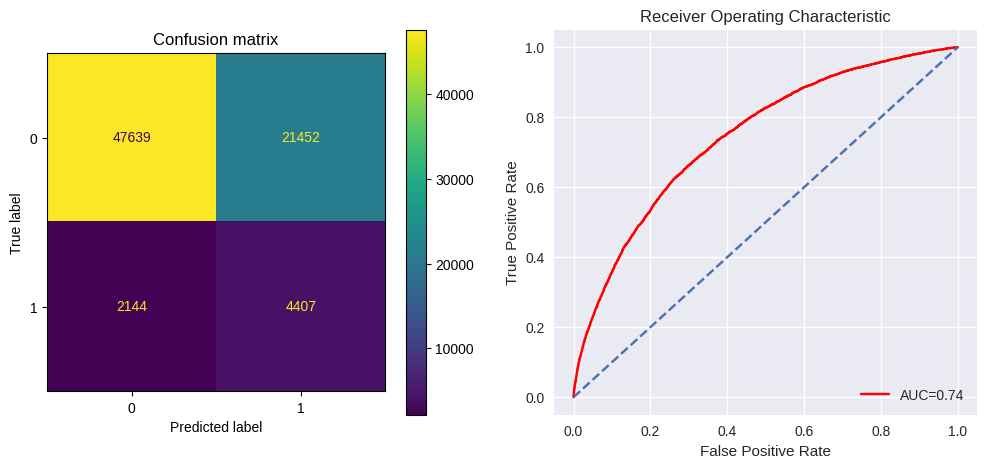

Balanced RandomForest: 


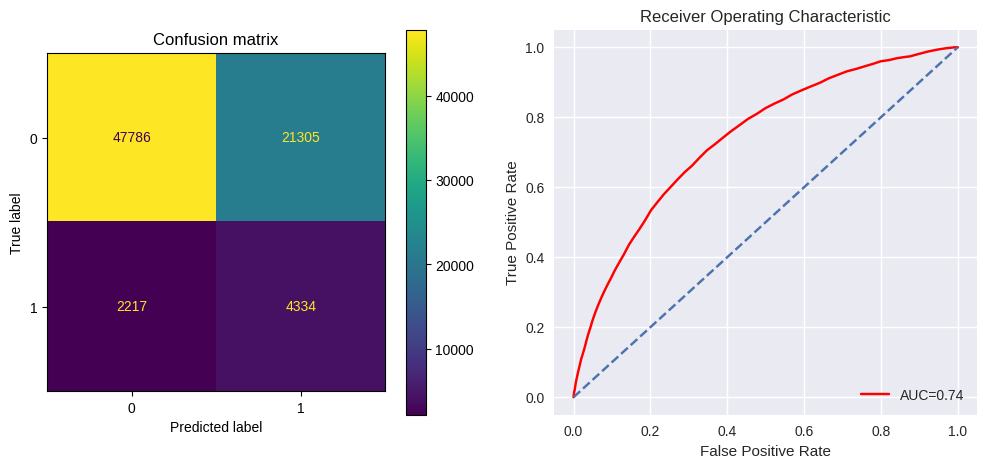

LightGBM: 


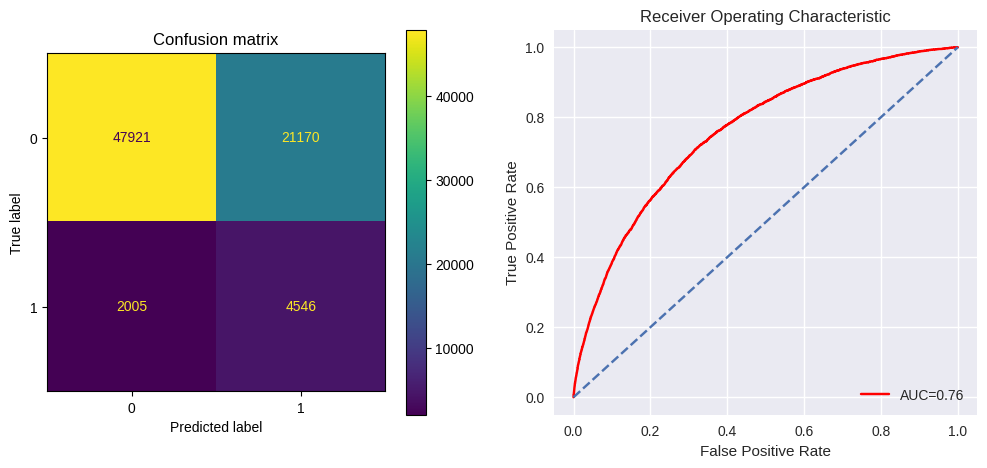

In [101]:
classification = classifiers_basic_comparison(np.array(X_train_res),
                                              np.array(X_test),
                                              y_train_res,
                                              y_test,
                                              classifiers,
                                              5)

In [102]:
# Comparison of the basic performances of the classifiers
classification

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,time (s)
Classifiers,,,,,,,,,,,,,
LightGBM,0.76,0.76,0.86,0.18,0.69,0.28,0.69,0.31,0.69,0.31,0.54,0.38,7.08
RUSBoost,0.75,0.74,0.76,0.17,0.67,0.27,0.67,0.31,0.69,0.33,0.52,0.52,26.39
Logistic Regression,0.74,0.74,0.75,0.17,0.69,0.27,0.69,0.32,0.68,0.31,0.52,0.39,3.04
Balanced RandomForest,0.74,0.74,1.00,0.17,0.66,0.27,0.66,0.31,0.69,0.34,0.51,0.42,31.89
Dummy Classifier (Baseline),0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.34


Undersampling results:

Much better than oversampling in terms of fbeta, and false negative rate. AUC remains unchanged.

### 1.5 Feature importance

In [103]:
model = LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1)

In [104]:
# Feature selection
selector = RFECV(
    estimator=model,
    step=1,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1)
selector = selector.fit(X_train_res, y_train_res)

In [105]:
ranking_df = pd.DataFrame({'Feature': list(X_train_res.columns)})
ranking_df['Rank'] = np.asarray(selector.ranking_)
ranking_df.sort_values('Rank', inplace=True)
relevant_features = ranking_df[ranking_df.Rank == 1]['Feature'].to_list()
print(len(relevant_features))
relevant_features

52


['POS_SK_DPD_DEF',
 'BUR_CNT_CREDIT_PROLONG',
 'BUR_AMT_CREDIT_SUM',
 'BUR_AMT_CREDIT_SUM_DEBT',
 'BUR_AMT_CREDIT_SUM_OVERDUE',
 'BUR_DAYS_CREDIT_UPDATE',
 'PAY_HIST_NUM_INSTALMENT_VERSION',
 'PAY_HIST_NUM_INSTALMENT_NUMBER',
 'PAY_HIST_DAYS_INSTALMENT',
 'PAY_HIST_AMT_INSTALMENT',
 'POS_CNT_INSTALMENT',
 'POS_SK_DPD',
 'REG_CITY_NOT_LIVE_CITY',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'PREV_AMT_ANNUITY',
 'PREV_AMT_DOWN_PAYMENT',
 'PREV_AMT_CREDIT',
 'PREV_RATE_DOWN_PAYMENT',
 'PREV_CNT_PAYMENT',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE_Higher education',
 'FLAG_EMAIL',
 'NAME_INCOME_TYPE_State servant',
 'CODE_GENDER_F',
 'PREV_APPLICATION_NUMBER',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'BUR_DAYS_CREDIT_ENDDATE',
 'PAYMENT_RATE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'BUR_DAYS

In [106]:
# Transformation of the training set and the test set
X_train_rfe = selector.transform(X_train_res)
X_test_rfe = selector.transform(X_test)

time: 1.68s
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     69091
           1       0.18      0.70      0.29      6551

    accuracy                           0.69     75642
   macro avg       0.57      0.70      0.55     75642
weighted avg       0.89      0.69      0.76     75642

AUC: 0.76
TPR: 0.70
FPR: 0.31
TNR: 0.69
FNR: 0.30


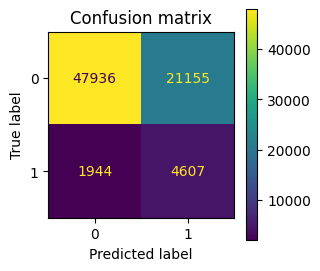

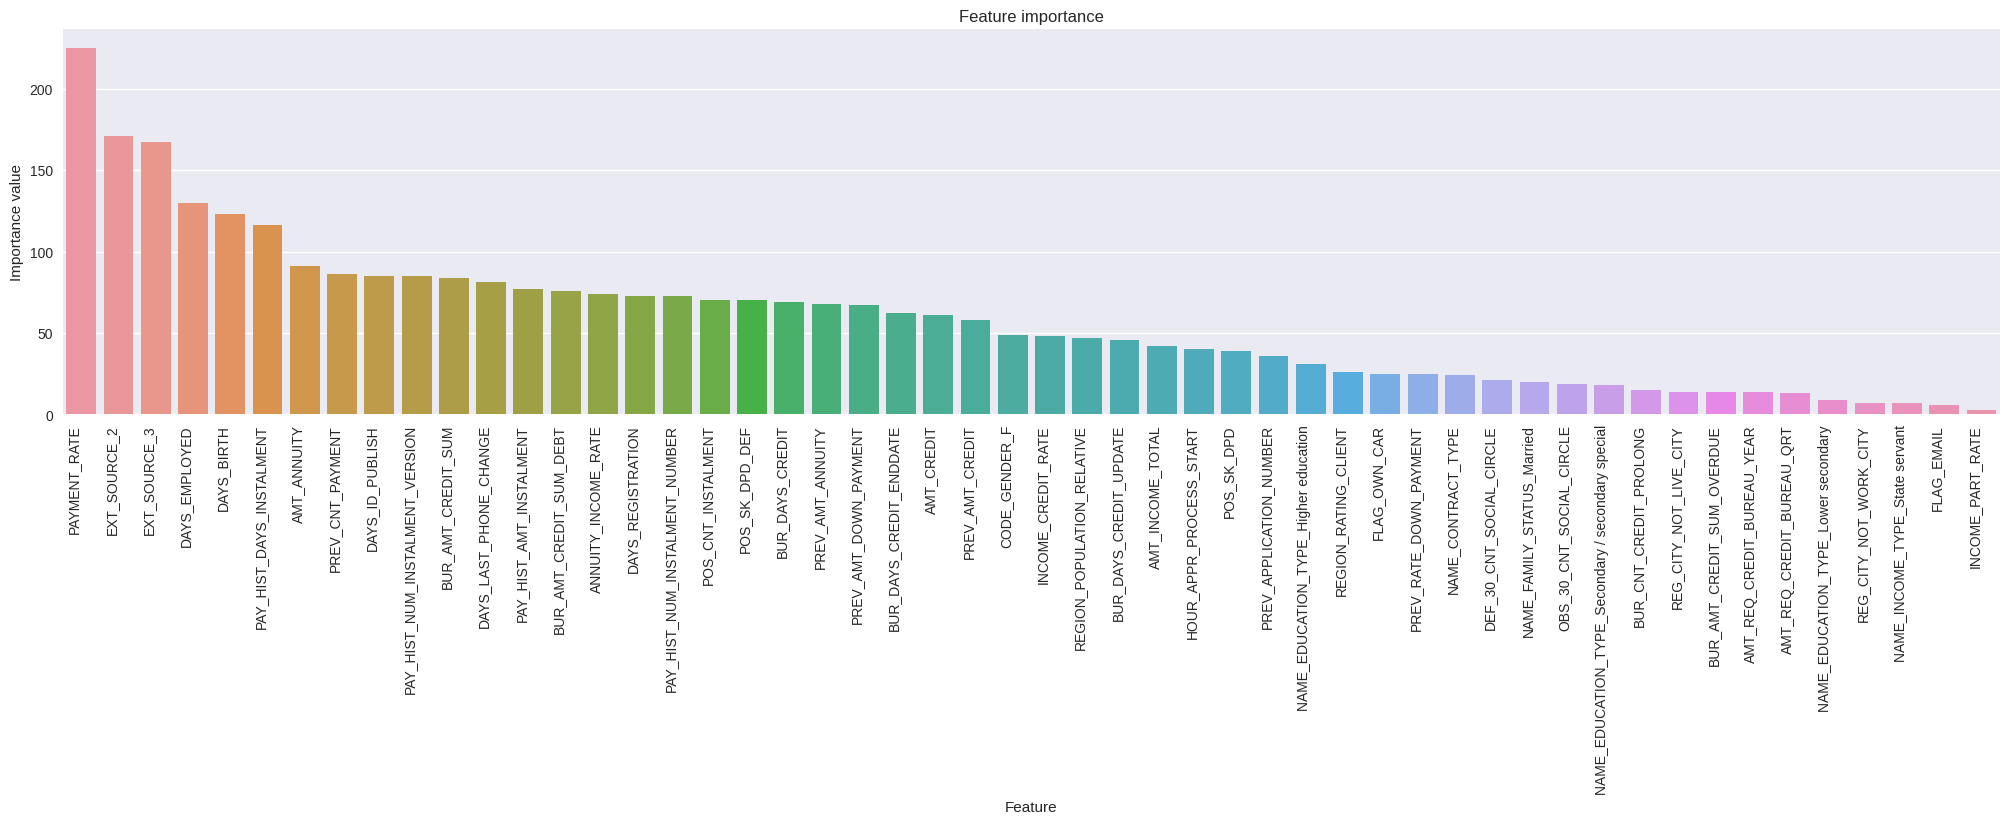

Number of relevant features: 52


In [107]:
# Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res[relevant_features],
                               X_test[relevant_features],
                               y_train_res,
                               y_test,
                               model,
                               True,
                               True,
                               None,
                               'roc_auc')
print("Number of relevant features: {}".format(len(features)))

## 2. Comparison of the different models

Cross validation for hyperparameter tuning of the best performing models.

In [108]:
# 2. Comparison of the different models
# 2.1 Classifiers comparaison by cross-validation
best_classifiers = {
    'LightGBM': [LGBMClassifier(),
        { 
          # Traditional Gradient Boosting Decision Tree
          'boosting_type': ['gbdt'],
          # Maximum tree leaves for base learners  
          'num_leaves': [15, 31],
          # Maximum tree depth for base learners 
          'max_depth': [-1, 6],
          # Learning rate shrinks the contribution of each tree
          'learning_rate': [0.05, 0.08, 0.1],
          # Number of boosted trees to fit
          'n_estimators': [100, 300],
          # Specify the learning task and the corresponding learning objective
          'objective': ['binary'],
          # Weights associated with classes in the form
          'class_weight': ['balanced'],
          # Subsample ratio of the training instance
          'subsample': [0.5, 1],
          # Subsample ratio of columns when constructing each tree
          'colsample_bytree': [1],
          # Random number seed
          'random_state': [0],
          # Number of parallel threads to use for training
          'n_jobs': [-1]
        }],
    'RUSBoost': [RUSBoostClassifier(),
        {
          # The base estimator from which the boosted ensemble is built
          # If None, the base estimator is DecisionTreeClassifier(max_depth=1)
          'base_estimator': [None],
          # The maximum number of estimators at which boosting is terminated
          'n_estimators': [100, 300],
          # Learning rate shrinks the contribution of each classifier
          'learning_rate': [0.1, 0.5, 0.6],
          # The boosting algorithm to use
          'algorithm': ['SAMME', 'SAMME.R'],
          # Whether or not to sample randomly with replacement or not
          'replacement': [False],
          # Control the randomization of the algorithm
          'random_state': [0]
        }],
    'Logistic Regression': [LogisticRegression(),
        {
          # Specify the norm of the penalty
          'penalty': ['l2'],
          # Dual or primal formulation
          'dual': [False],
          # Inverse of regularization strength; must be a positive float
          # Like in SVM, smaller values specify stronger regularization
          'C': np.logspace(-3, 3, 3),
          # Specifies if a constant should be added to the decision function
          'fit_intercept': [True],
          # Weights associated with classes in the form
          'class_weight': ['balanced'],
          # Used when solver='sag', 'saga' or 'liblinear' to shuffle the data
          'random_state': [0],
          # Algorithm to use in the optimization problem
          'solver': ['lbfgs', 'liblinear'],
          # Maximum number of iterations taken for the solvers to converge
          'max_iter': [100, 300],
          # Number of CPU cores used when parallelizing over classes
          'n_jobs': [None]
        }]
}

LightGBM: 
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 15, 'objective': 'binary', 'random_state': 0, 'subsample': 0.5}


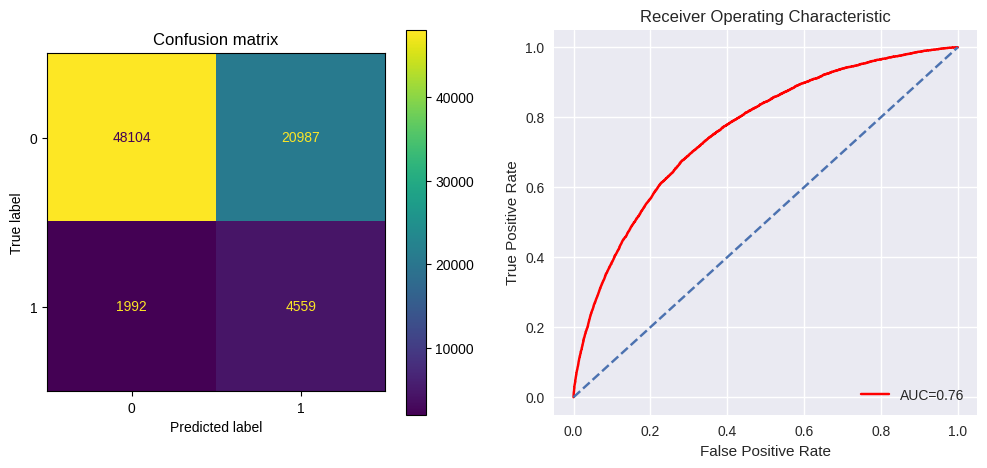

RUSBoost: 
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.6, 'n_estimators': 300, 'random_state': 0, 'replacement': False}


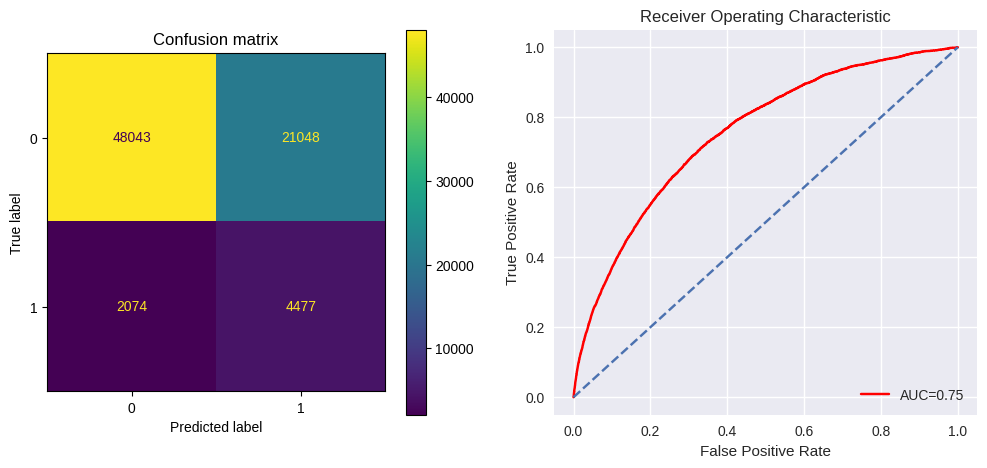

Logistic Regression: 
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'max_iter': 100, 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs'}


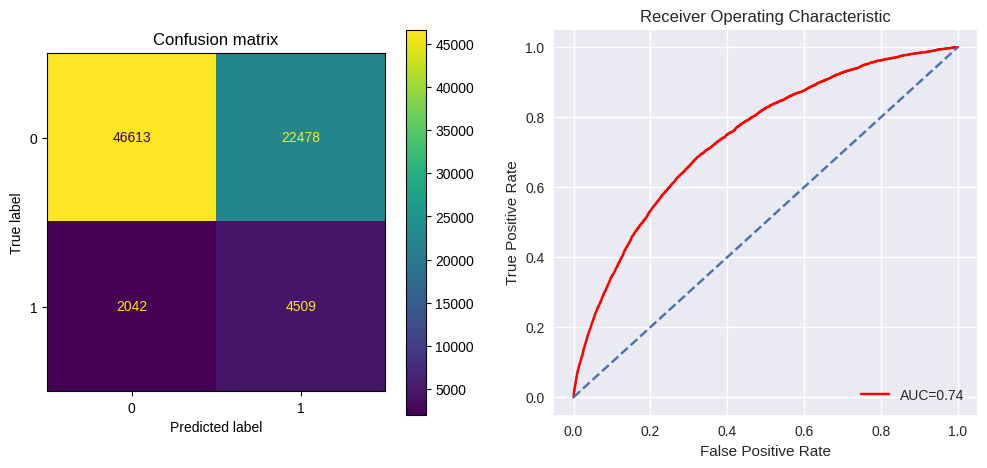

In [109]:
params, cv_classification = classifiers_comparison(X_train_rfe,
                                                   X_test_rfe,
                                                   y_train_res,
                                                   y_test,
                                                   best_classifiers,
                                                   5)

In [110]:
# Comparison of the performances of optimized classifiers
cv_classification

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,fit-time (s)
Classifiers,,,,,,,,,,,,,
LightGBM,0.76,0.76,0.82,0.18,0.70,0.28,0.70,0.30,0.70,0.30,0.54,0.38,188.68
RUSBoost,0.75,0.75,0.78,0.18,0.68,0.28,0.68,0.30,0.70,0.32,0.53,0.53,396.57
Logistic Regression,0.74,0.74,0.75,0.17,0.69,0.27,0.69,0.33,0.67,0.31,0.52,0.39,8.96


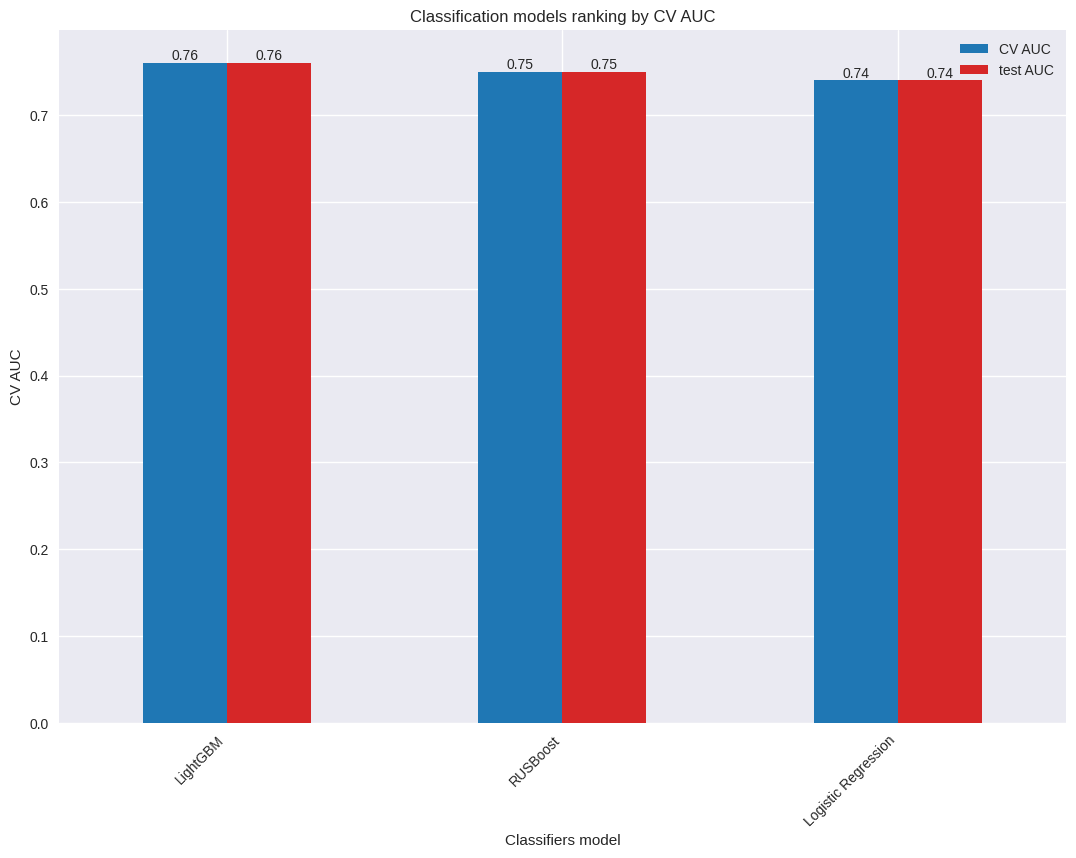

In [111]:
# Classifiers ranking by the cross-validation AUC score
dataviz = cv_classification[['Cross-validation AUC', 'Prediction AUC']]
dataviz = dataviz.rename(columns={'Cross-validation AUC': 'CV AUC',
                        'Prediction AUC': 'test AUC'})
display_histogram(
    dataviz, 'CV AUC', False, (13, 9), ['tab:blue', 'tab:red'])

We can clearly see that LightGBM is the best interms of auc.

### 2.2 Selection of the final model

Le modèle final sélectionné est le LightGBM, un framework du gradient boosting :
- Rapide (utilisation réduite de la mémoire) ; 
- Efficace (une meilleure précision) ;
- Optimisé (prise en charge de l'apprentissage parallèle, distribué sur GPU et capable de traiter de grande taille de données).

time: 3.05s
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     69091
           1       0.18      0.70      0.28      6551

    accuracy                           0.70     75642
   macro avg       0.57      0.70      0.55     75642
weighted avg       0.89      0.70      0.76     75642

AUC: 0.76
TPR: 0.70
FPR: 0.30
TNR: 0.70
FNR: 0.30


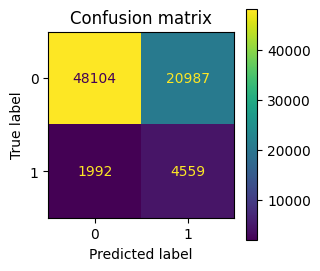

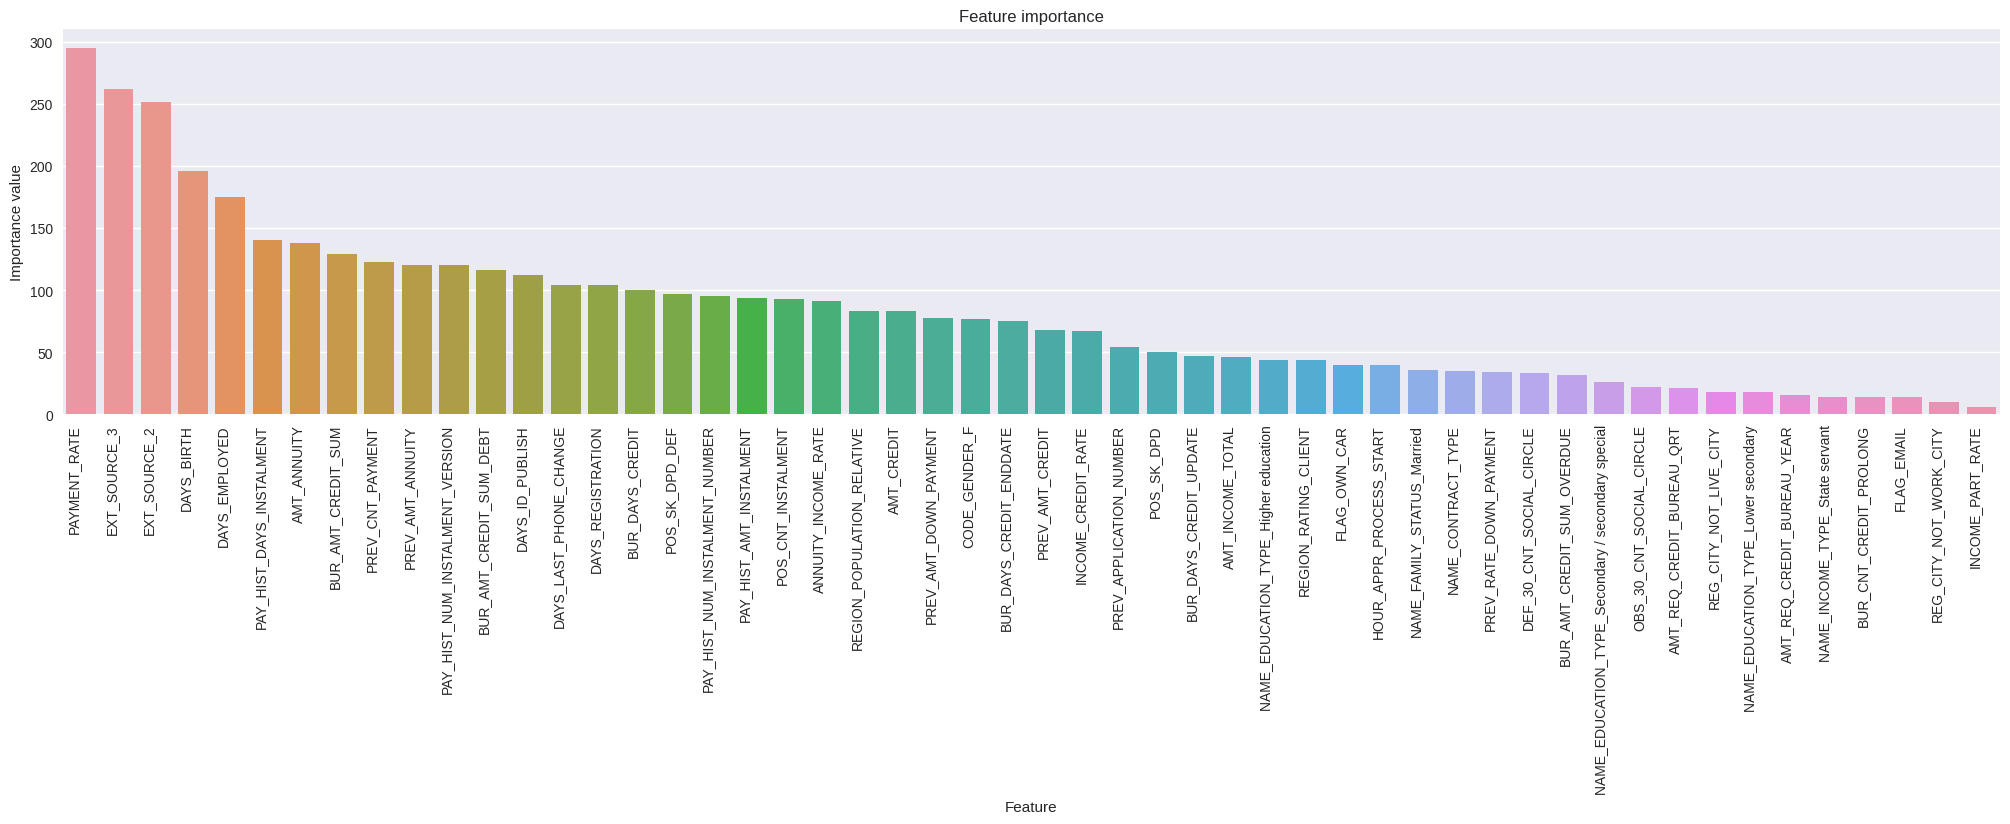

Number of relevant features: 52


In [112]:
# 2.2 Selection of the final model
# Global and local interpretability of the model
hyperparams = {
    'boosting_type': params[0]['boosting_type'],
    'num_leaves': params[0]['num_leaves'],
    'max_depth': params[0]['max_depth'],
    'learning_rate': params[0]['learning_rate'],
    'n_estimators': params[0]['n_estimators'],
    'objective': params[0]['objective'],
    'class_weight': params[0]['class_weight'],
    'subsample': params[0]['subsample'],
    'colsample_bytree': params[0]['colsample_bytree'],
    'random_state': params[0]['random_state'],
    'n_jobs': params[0]['n_jobs']
}
classifier = LGBMClassifier(**hyperparams)

# Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res[relevant_features],
                               X_test[relevant_features],
                               y_train_res,
                               y_test,
                               classifier,
                               True,
                               True,
                               None,
                               'roc_auc')
print("Number of relevant features: {}".format(len(features)))

On observe que :
- Le score du modèle en prédiction est identique au score en validation croisée ;
- Le rappel est identique pour les deux classes avec une valeur de 0,7 proche de 1 ;
- La précision est élevée pour la classe 0 (0,96) mais faible pour la classe 1 (0,18).

time: 3.16s


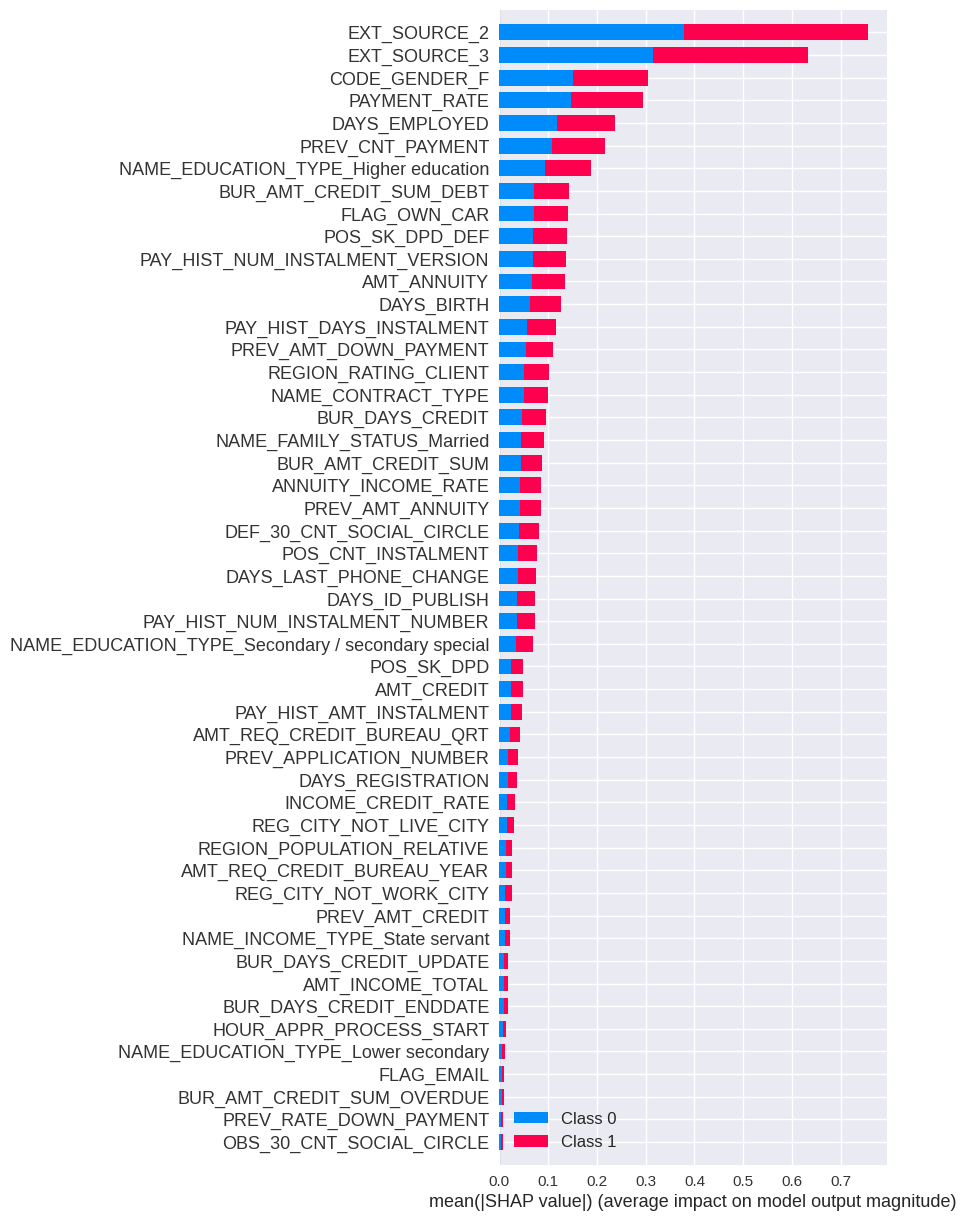

In [113]:
# Local interpretability of the model
# SHAP explanations
feature_engineering(X_train_res[relevant_features],
                    X_test[relevant_features],
                    y_train_res,
                    y_test,
                    classifier,
                    False,
                    False,
                    50,
                    'roc_auc')

## 3. The business cost function, the optimization algorithm,and the evaluation metric

La fonction coût est une estimation du gain financier ou de perte financière pour l’entreprise. Il s’agit d’une problématique métier et l’objectif est de minimiser :
- Le nombre de clients ayant des situations sans risque de défaut de paiement dont les demandes de crédits sont refusées par erreur (l’erreur de type I ou les faux positifs) ;
- Le nombre de crédits accordés par erreur aux clients ayant des risques élevés de défaut de paiement (l’erreur de type II ou les faux négatifs).

Pour atteindre cet objectif, il faut :
- Maximiser le rappel et la précision ;
- Minimiser le taux de faux positifs (FPR) et le taux de faux négatifs (FNR).

Le rappel, la précision, le FPR et le FNR sont calculés de la manière suivante :
$$
recall = \frac{TP}{TP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
FPR = \frac{FP}{TN+FP}
$$
$$
FPR = \frac{FN}{TP+FN}
$$

La métrique d’évaluation est le "credit score", une fonction perte calculée à partir du F-beta score :
$$
F_{β}=(1+β^2) \cdot \frac{precision \cdot recall}{β^2 \cdot precision+recall}
$$
$$
credit \ score=1-F_{β}
$$

L’enjeu ici est de trouver le bon compromis entre le rappel et la précision et cela dépend du choix de la valeur de β :
- Si β < 1, la précision a plus de poids dans l’évaluation (on pénalise plus les faux positifs) ;
- Si β = 1, la précision et le rappel ont un des poids identiques dans l’évaluation (on obtient dans ce cas le F1 score) ;
- Si β > 1, le rappel a plus de poids dans l’évaluation (on pénalise plus les faux négatifs).

Nous avons sélectionné, la valeur de β égale à 3 pour donner plus de poids au rappel afin de plus pénaliser les faux négatifs par rapport aux faux positifs.

Pour déterminer la classe (0 ou 1) d’un client, un seuil de décision est déduit à partir de la courbe de précision et rappel. La valeur calculée vaut 0,37.

In [114]:
# 3. The business cost function, the optimization algorithm,
# and the evaluation metric
# 3.1 The business cost function and the evaluation metric
def credit_score(model, X, y, β=3):
    """This function uses credit_score, a loss score,
    to penalize FNR and FPR.
    """
    y_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
    idx = argmax(fβscore)
    best_threshold = thresholds[idx]
    y_pred = np.where(y_proba > best_threshold, 1, 0)
    fβ_score = fbeta_score(y, y_pred, beta=β)
    credit_score = 1 - fβ_score
    return credit_score


def scores_analysis(model, X_test, y_test, β):
    """This function calculates Fβ and Credit scores
    according to the best threshold and displays visualizations.
    """
    # Making prediction
    y_proba =  model.predict_proba(X_test)[:, 1]
    
    # Get the best threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
    idx = argmax(fβscore)
    best_threshold = thresholds[idx]
    
    # Fβ and Credit scores calculation
    y_pred = np.where(y_proba > best_threshold, 1, 0)
    counter = Counter(y_pred)
    Fβ_score = fbeta_score(y_test, y_pred, beta=β)
    Credit_score = 1 - Fβ_score
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Displaying results
    print('\nFβ score: {:.2f}'.format(Fβ_score))
    print('Credit score: {:.2f}'.format(Credit_score))
    print('\nBest threshold: {:.2f}'.format(best_threshold))
    print("Class 0: {}".format(counter[0]))
    print("Class 1: {}".format(counter[1]))
    print("\nTP: {}".format(tp))
    print("TN: {}".format(tn))
    print("FP: {}".format(fp))
    print("FN: {}".format(fn))
    print("\nTPR: {:.2f}".format(tp / (tp + fn)))
    print("TNR: {:.2f}".format(tn / (tn + fp)))
    print("FPR: {:.2f}".format(fp / (fp + tn)))
    print("FNR: {:.2f}".format(fn / (fn + tp)))
    
    # Plots
    # Precision Recall curve
    plt.style.use('seaborn')
    plt.plot(recall, precision, color='green')
    plt.axis('tight')
    plt.title('Precision Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    probas = np.linspace(0, 1, num=11)
    credit_score = []
    fβ_score = []
    fnrs = []
    fprs =[]
    for proba in probas:
        y_pred = np.where(y_proba >= proba, 1, 0)
        fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        credit_score.append(1-fbeta_score(y_test, y_pred, beta=β))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnrs.append(fn / (fn + tp))
        fprs.append(fp / (fp + tn))
    
    plt.plot(probas, fβ_score,
             'o-', color='tab:blue', label='fβ score')
    plt.plot(probas, credit_score,
             'o-', color='tab:red', label='credit score')
    plt.plot(probas, fnrs,
             'o-', color='tab:green', label='false negative rate')
    plt.plot(probas, fprs,
             'o-', color='tab:purple', label='false positive rate')
    plt.legend(loc='center right')
    plt.title('fβ_score, credit_score, FNR and FPR curves')
    plt.xlabel('class probabilities')
    plt.ylabel('fβ_score, credit_score, FNR, FPR')
    plt.xticks(rotation=0)
    plt.show()
    

def best_params_search(space):
    """This function applies cross-validation by using Hyperopt
    to find the best parameters of an estimator.
    """
    params = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'n_estimators': int(space['n_estimators']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'min_child_weight': space['min_child_weight'],
        'min_child_samples': int(space['min_child_samples'])
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model,
                            np.array(X_train_res[relevant_features]),
                            y_train_res,
                            cv=StratifiedKFold(n_splits=5),
                            scoring=credit_score,
                            error_score='raise',
                            n_jobs=-1).mean()
    return score

### 3.2 The optimization algorithm

The LightGBM model is used. The best hperparameters that will give us the lowest credit score, the function that we are trying to minimise will be found using Hyperopt.

In [115]:
# 3.2 The optimization algorithm
β = 3
param_grid = {
    'num_leaves': hp.uniform('num_leaves', 10, 30),
    'max_depth': hp.uniform('max_depth', -1, 7),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.uniform('n_estimators', 100, 500),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': hp.uniform('min_child_samples', 10, 20)
}

# Best hyperparameters search
best = fmin(
    # Function to optimize
    fn=best_params_search,
    # Parametrs
    space=param_grid,
    # Optimization algorithm
    # Hyperopt select its parameters automatically
    algo=tpe.suggest,
    # Maximum number of iterations
    max_evals=25,
    # Random generator seed
    rstate=np.random.seed(0),
    # Trials contains logging information
    trials=Trials()
)
print(best)

100%|██████████| 25/25 [02:00<00:00,  4.82s/it, best loss: 0.08978440003805106]
{'colsample_bytree': 0.2299457743736366, 'learning_rate': 0.17349388624785567, 'max_depth': 5.676270572429955, 'min_child_samples': 11.680351544224951, 'min_child_weight': 0.08770810633762527, 'n_estimators': 244.27892151960165, 'num_leaves': 26.841774607355916, 'reg_alpha': 0.8492526652248362, 'reg_lambda': 0.30321396351667107, 'subsample': 0.8380598602104432}


In [116]:
# Applying optimal hyperparameters to the model
hyperparams = {
    'boosting_type': 'gbdt',    
    'num_leaves': 26,
    'max_depth': 5,
    'learning_rate': 0.1020595190892737,
    'n_estimators': 362,
    'subsample': 0.8291093582700603,
    'colsample_bytree': 0.24340444871567768,
    'reg_alpha': 0.7823246140877455,
    'reg_lambda': 0.1999818973400066,
    'min_child_weight': 0.31620378372118596,
    'min_child_samples': 11,
    'class_weight': 'balanced',
    'random_state': 0,
    'n_jobs': -1
}
model = LGBMClassifier(**hyperparams)

We train our optimised model on training data.

In [117]:
# Training the model
model.fit(np.array(X_train_res[relevant_features]), y_train_res)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.24340444871567768,
               learning_rate=0.1020595190892737, max_depth=5,
               min_child_samples=11, min_child_weight=0.31620378372118596,
               n_estimators=362, num_leaves=26, random_state=0,
               reg_alpha=0.7823246140877455, reg_lambda=0.1999818973400066,
               subsample=0.8291093582700603)

### 3.3 Results of applying the business cost function and evaluation metrics


Fβ score: 0.56
Credit score: 0.44

Best threshold: 0.35
Class 0: 34675
Class 1: 40967

TP: 5592
TN: 33716
FP: 35375
FN: 959

TPR: 0.85
TNR: 0.49
FPR: 0.51
FNR: 0.15


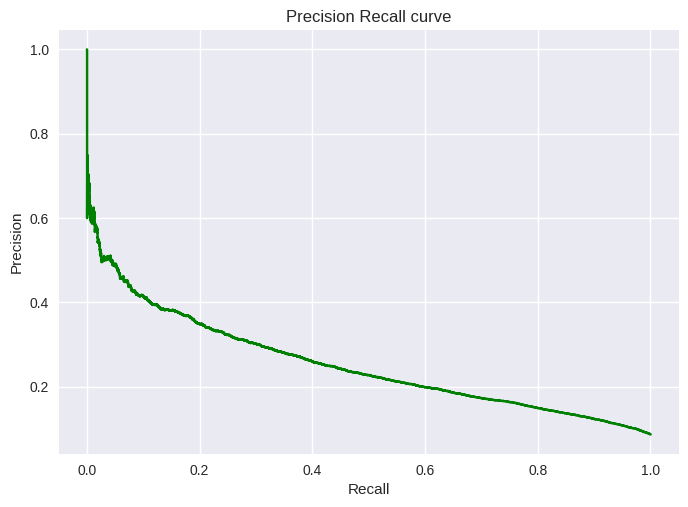

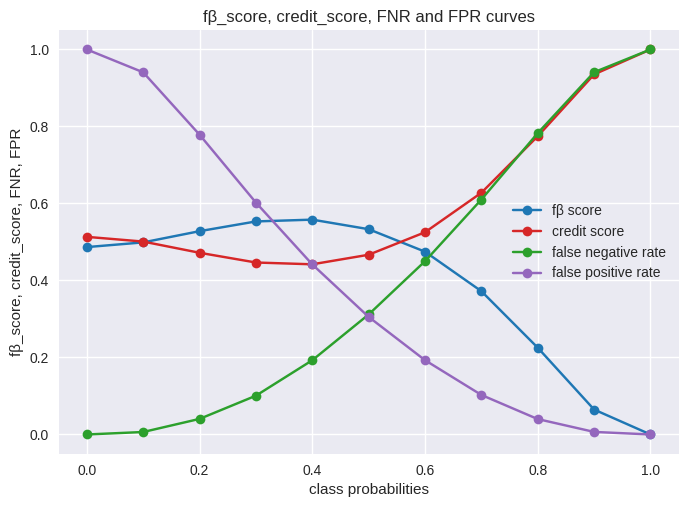

In [118]:
# 3.3 Results of applying the business cost function and evaluation metrics
scores_analysis(model, X_test[relevant_features], y_test, β)

## 4. Global and Local interpretability of the model

### 4.1 Global interpretability

time: 2.37s


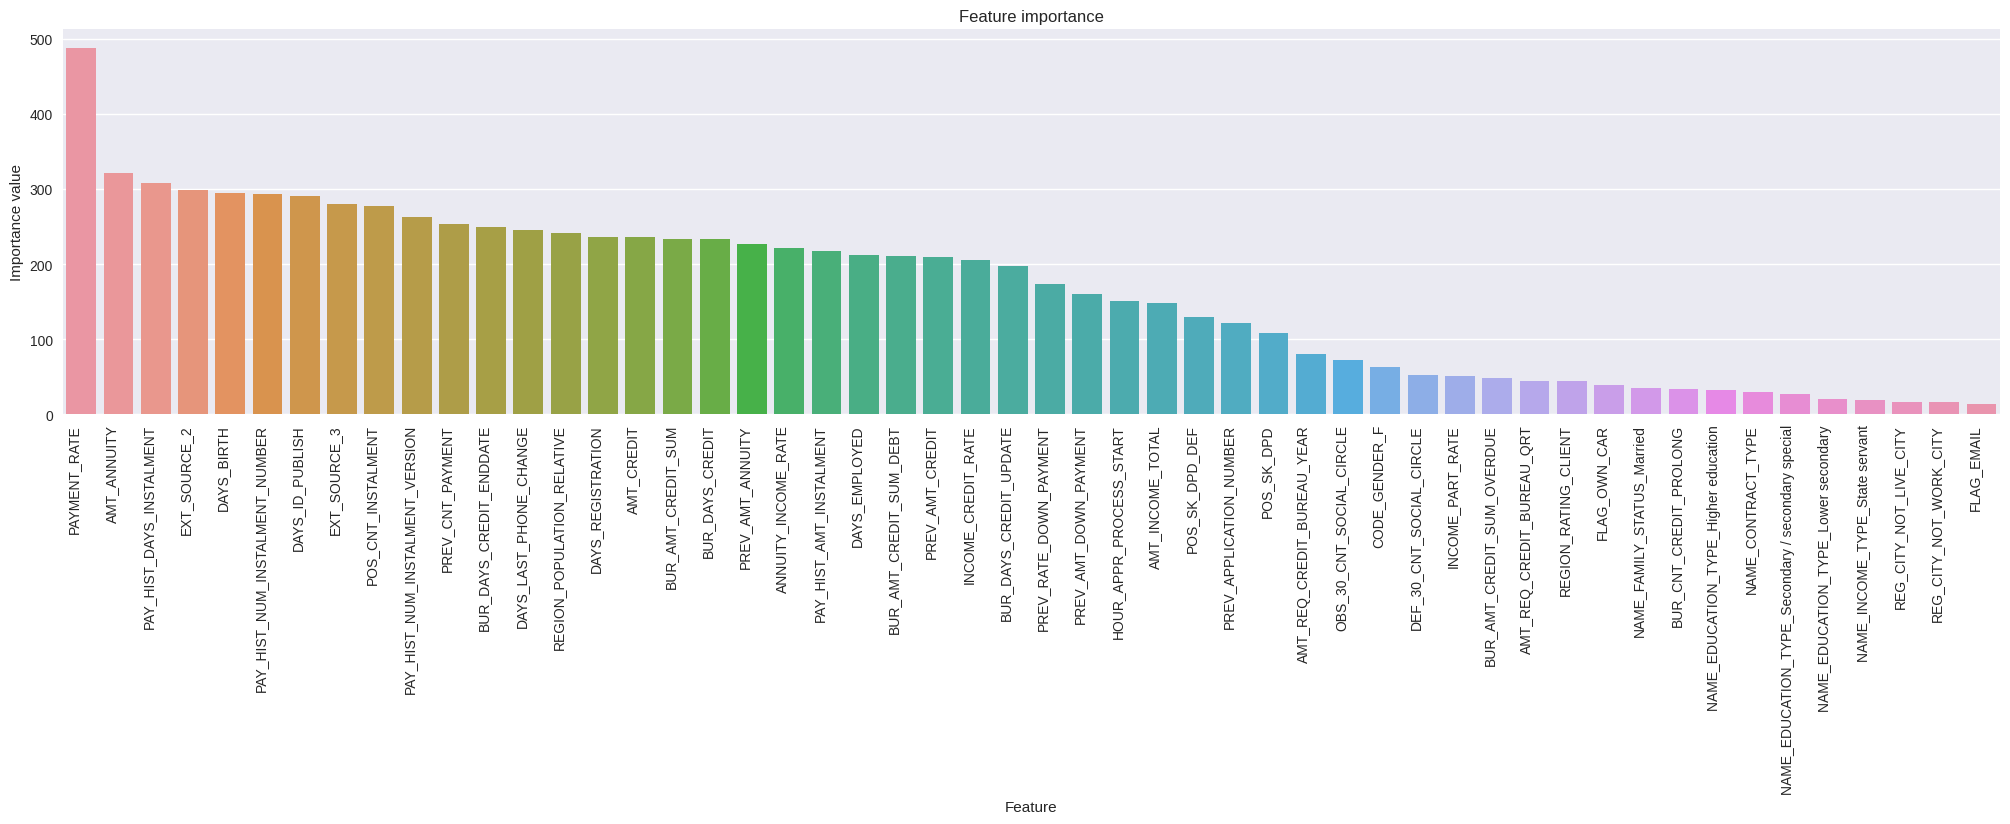

Number of relevant features: 52


In [119]:
# 4. Global and local interpretability of the model
# 4.1 Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res[relevant_features],
                               X_test[relevant_features],
                               y_train_res,
                               y_test,
                               model,
                               False,
                               True,
                               None,
                               credit_score)
print("Number of relevant features: {}".format(len(features)))

This level of interpretability is about understanding how the model makes decisions, based on a holistic view of its features.

### 4.2 Local interpretability

time: 2.34s


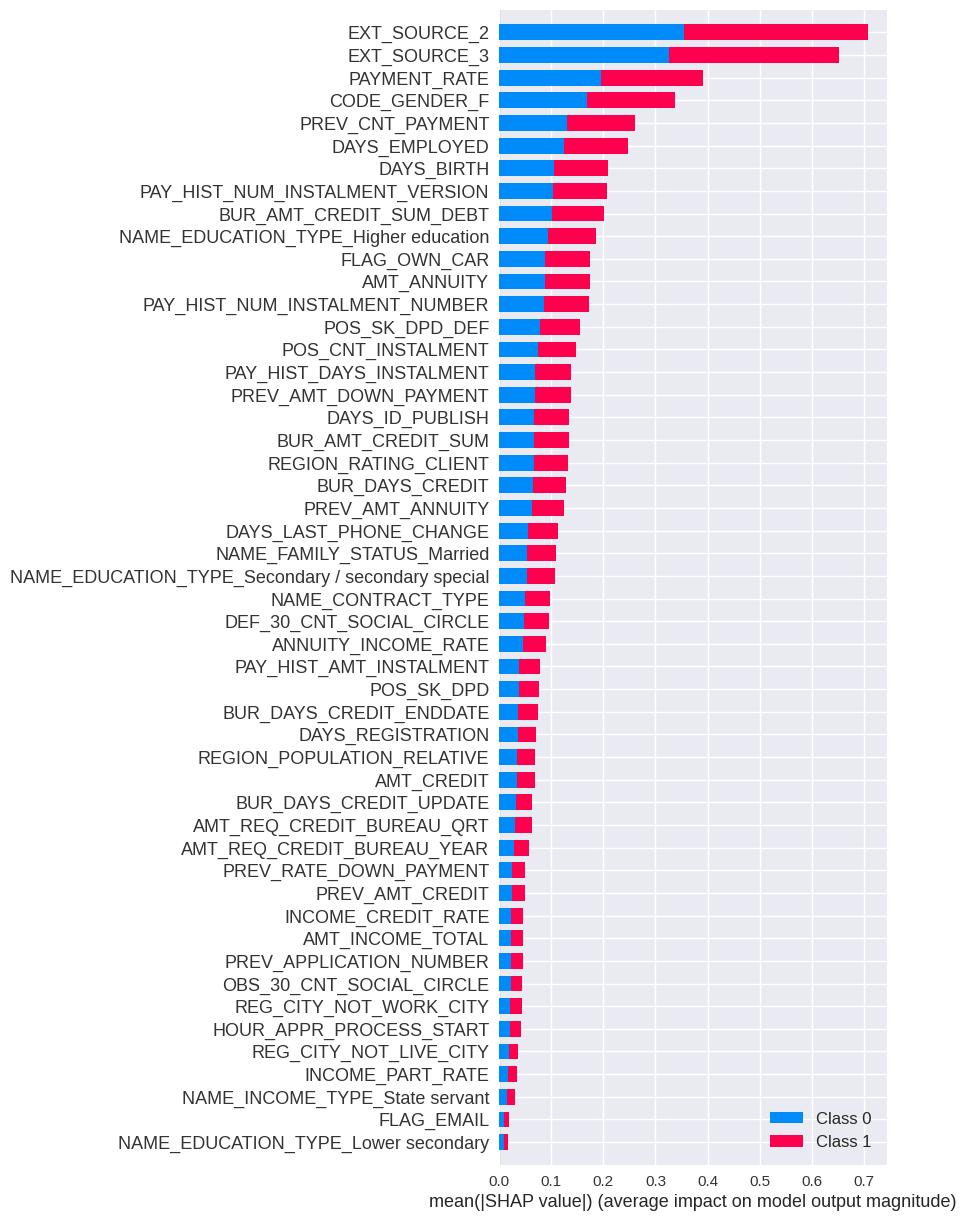

In [120]:
# 4.2 Local interpretability of the model
# SHAP explanations
feature_engineering(X_train_res[relevant_features],
                    X_test[relevant_features],
                    y_train_res,
                    y_test,
                    model,
                    False,
                    False,
                    50,
                    credit_score)

This level of interpretability is about understanding a single prediction of a model.

## 5. Serialization of models

### 5.1 Serialization of the optimization algorithm

All serialisation is done using pickle.

In [121]:
# 5. Serialization of models
# 5.1 Serialization of the optimization algorithm
pickle.dump({'model': model}, open('model' + ".pkl", "wb"))

### 5.2 Serialization of transformations (imputations, normalisation et standardisation)

In [122]:
# 5.2 Serialization of transformations
# (imputations, normalization and standardization)
# Serializing the numerical imputer
pickle.dump({'num_imputer': num_imputer}, open('num_imputer' + ".pkl", "wb"))

In [123]:
# Serializing the binary imputer
pickle.dump({'bin_imputer': bin_imputer}, open('bin_imputer' + ".pkl", "wb"))

In [124]:
# Serializing the transformer
pickle.dump({'transformer': transformer}, open('transformer' + ".pkl", "wb"))

In [125]:
# Serializing the scaler
pickle.dump({'scaler': scaler}, open('scaler' + ".pkl", "wb"))

## 6. Conclusion

- Le nombre de faux positifs est élevé ;
- Il n’est pas possible d’avoir à la fois un bon rappel et une bonne précision ;
- Pour mieux choisir la valeur de bêta, il faut bien connaître le secteur d’activité et les attentes de l’entreprise ;
- L’application de l’article 22 du RGPD permet de contrôler le risque du modèle ;
- Pour s’assurer que le modèle est toujours en phase avec la réalité, il faut :
  - Mettre en place un système de monitoring de la performance ;
  - Réentraîner le modèle avec plus de données.

In [126]:
data.NAME_INCOME_TYPE.unique()

array(['Working', 'State servant', 'Commercial associate', 'Student',
       'Pensioner', 'Businessman', 'Maternity leave'], dtype=object)

In [127]:
X_test[relevant_features].head()

,POS_SK_DPD_DEF,BUR_CNT_CREDIT_PROLONG,BUR_AMT_CREDIT_SUM,BUR_AMT_CREDIT_SUM_DEBT,BUR_AMT_CREDIT_SUM_OVERDUE,BUR_DAYS_CREDIT_UPDATE,PAY_HIST_NUM_INSTALMENT_VERSION,PAY_HIST_NUM_INSTALMENT_NUMBER,PAY_HIST_DAYS_INSTALMENT,PAY_HIST_AMT_INSTALMENT,...,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,NAME_FAMILY_STATUS_Married,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_RATE,INCOME_CREDIT_RATE,INCOME_PART_RATE,OBS_30_CNT_SOCIAL_CIRCLE,REG_CITY_NOT_WORK_CITY
0,0.0,0.0,-0.445403,-0.889314,0.0,0.854074,1.538371,-0.288651,-0.102006,0.779717,...,0.0,-0.825837,1,0.0,1.000000,-0.186843,0.046444,0.000000,0.000000,0
1,0.0,0.0,-1.412912,-0.889314,0.0,-2.275897,0.000000,0.000000,0.000000,0.000000,...,0.0,-2.058717,1,0.0,-4.617233,0.153532,0.208130,0.000000,0.937973,0
2,0.0,0.0,-0.430728,0.000000,0.0,-1.478575,0.250845,0.111298,0.600004,1.057867,...,0.0,-0.008082,1,0.0,-4.617233,-1.363169,0.790793,0.000000,0.937973,1
3,0.0,0.0,-0.763682,-0.889314,0.0,0.770737,-0.386547,-0.641865,0.222312,0.355176,...,0.0,3.863241,0,0.0,1.000000,-0.213839,0.935993,5.337445,1.048488,1
4,0.0,0.0,-0.624372,-0.889314,0.0,-0.645959,0.403291,-0.381089,0.199365,0.884795,...,0.0,-0.705183,1,0.0,1.649950,0.423942,-0.285334,0.000000,0.000000,1


In [128]:
#taking a sample for the dashboard.
data_sample= data.sample(n=20000, random_state=3)

In [129]:
data_sample.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,PREV_AMT_ANNUITY,PREV_AMT_DOWN_PAYMENT,PREV_AMT_CREDIT,PREV_RATE_DOWN_PAYMENT,PREV_CNT_PAYMENT,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE
59439,183968,1,1,1,0,0.0,472500.0,450000.0,48595.5,0.010032,...,19722.91500,11911.50,145021.50,0.082664,8.0,M,State servant,Secondary / secondary special,Married,House / apartment
74495,205320,1,0,0,0,0.0,112500.0,180000.0,8752.5,0.008474,...,5593.32750,1620.00,62782.00,0.051725,13.0,M,Working,Secondary / secondary special,Single / not married,House / apartment
204522,388673,1,0,0,0,0.0,94500.0,288873.0,11020.5,0.025164,...,30457.99125,NaN,477764.25,NaN,42.0,F,Working,Secondary / secondary special,Married,House / apartment
239925,438879,1,0,1,0,0.0,270000.0,1023691.5,54670.5,0.072508,...,12291.51375,6540.75,105914.25,0.050000,12.0,F,Commercial associate,Secondary / secondary special,Single / not married,House / apartment
196111,377020,1,1,1,0,0.0,256500.0,323194.5,16501.5,0.030755,...,23457.96000,5967.00,316923.50,0.065420,25.0,F,Working,Secondary / secondary special,Married,House / apartment


In [130]:
data_sample.drop(["TARGET"], axis=1, inplace=True)

In [131]:
# exporting dataset
data_sample.to_csv('data.csv', index=False)

In [132]:
! zip model.zip *.pkl

updating: bin_imputer.pkl (deflated 55%)
updating: model.pkl (deflated 59%)
updating: num_imputer.pkl (deflated 45%)
updating: scaler.pkl (deflated 40%)
updating: transformer.pkl (deflated 68%)


In [133]:
! zip data.zip *.csv

updating: data.csv (deflated 69%)


In [134]:
relevant_features

['POS_SK_DPD_DEF',
 'BUR_CNT_CREDIT_PROLONG',
 'BUR_AMT_CREDIT_SUM',
 'BUR_AMT_CREDIT_SUM_DEBT',
 'BUR_AMT_CREDIT_SUM_OVERDUE',
 'BUR_DAYS_CREDIT_UPDATE',
 'PAY_HIST_NUM_INSTALMENT_VERSION',
 'PAY_HIST_NUM_INSTALMENT_NUMBER',
 'PAY_HIST_DAYS_INSTALMENT',
 'PAY_HIST_AMT_INSTALMENT',
 'POS_CNT_INSTALMENT',
 'POS_SK_DPD',
 'REG_CITY_NOT_LIVE_CITY',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'PREV_AMT_ANNUITY',
 'PREV_AMT_DOWN_PAYMENT',
 'PREV_AMT_CREDIT',
 'PREV_RATE_DOWN_PAYMENT',
 'PREV_CNT_PAYMENT',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'NAME_EDUCATION_TYPE_Higher education',
 'FLAG_EMAIL',
 'NAME_INCOME_TYPE_State servant',
 'CODE_GENDER_F',
 'PREV_APPLICATION_NUMBER',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'BUR_DAYS_CREDIT_ENDDATE',
 'PAYMENT_RATE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'BUR_DAYS